# Evaluating Gene Correlations - DE

In [26]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
import scanpy as sc
import sklearn.metrics
import seaborn as sns
import scipy

import matplotlib
from scipy.spatial import cKDTree
import sys
sys.path.append('/home/icb/manuel.gander/Reproducibility_TOME/Utils')

# Utils contains some functions I use a lot
import Utils

#sc.settings.verbosity = 0

In [27]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"

# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]


t2=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[9.5+x for x in range(0,5)]

# Growth of embryo:
#    - cells corresponds to the estimated total amount of cells in the embryo for each time point
#    - av_g corresponds to the average grwoth rate of the embryo at each specific time point
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 200000, 1100000, 2600000, 6000000, 13000000 ]
av_g=np.zeros(len(t2)-1)
for i in range(0,len(av_g)):
    av_g[i]=cells[i+1]/cells[i]/(t2[i+1]-t2[i])

In [28]:
pal=sns.color_palette()
pals=pal.copy()
pals[0]=pal[1]
pals[1]=pal[0]

# Load anndatas and maps

In [29]:
ct='Definitive endoderm'
i=7


ts0=ts[i]
print(ts0)
ts1=ts[i+1]

(A0,  A1)=Utils.load_adata(ts0, ts1)

adata=A0.concatenate(A1, join='outer', index_unique=None)
#sc.pp.neighbors(adata, use_rep='X_pcaS')
#sc.tl.umap(adata)

E7.0


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [30]:
eps=0.01

gT=np.load(f"{Path}/TOME-maps/Gene_cor_{ts0}_{ct}.npy", allow_pickle=True)
gM=np.load(f"{Path}/Moscot-maps/Gene_cor_{ts0}_{ct}_{eps}.npy", allow_pickle=True)
gT = dict(enumerate(gT.flatten(), 1))[1]['g']
gM = dict(enumerate(gM.flatten(), 1))[1]['g']


gT=gT/gT.sum()*len(A1[A1.obs['cell_type']==ct])*cells[11]/cells[10]
gM=gM/gM.sum()*len(A1[A1.obs['cell_type']==ct])*cells[11]/cells[10]

In [31]:
zT=np.zeros(len(adata))
zT[:len(gT)]=gT
adata.obs['Pull_TOME']=zT

zM=np.zeros(len(adata))
zM[:len(gM)]=gM
adata.obs['Pull_Moscot']=zM

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

In [45]:
# Definitive endoderm

# Nodal is meso+endoderm specific, but seems to be involed more in endoderm !!!,Nodal=Smad?
# Noggin (Nog) and Chordin maybe not, mybe to mesoendodermal

D={}

D['PMID: 34988400']=['Sox17', 'Nodal', 'Tdgf1', 'Inhba']

D['PMID: 30038254']=['Foxa2']

# Organoids, hence rather weak evidence
D['PMID: 24973948']=['Nanog','Eomes', 'Gata6','Smad2']

# Most genes in here are only linked to lack of endoderm formation in the respective double negative mutant mouse,
# hence gene expression of endoderm cells does not necessarily have to correlate...
D['PMID: 17387317']=['Amot', 'Mixl1', 'Nckap1', 'Lhx1', 'Inhba', 'Foxh1']


# weak-ish evidence
D['PMID: 16752393']=['Gata4', 'Furin', 'Nodal', 'Mixl1', 'Ctnnb1',
                    'Cdx2', 'Otx2', 'Lhx1','Pax1', 'Pax9', 'Hoxa3', 'Fgf8', 'Shh', 'Tbx1', 'Hoxa13', 
                     'Gata5',  'Iapp', 'Pklr', 'Smad3' ]
# strong evidence:
D['PMID: 16752393, strong evidence']=['Hnf4a', 'Ihh', 'Afp', 'Alb', 'Foxa2',  'Dkk1', 'Cer1', 'Sox17', 'Irx3', 
                     'Irx1', 'Pax1', 'Hhex', 'Bmpr1a']

D['PMID: 18213590']=['Cldn6',  'Shh', 'Sox17', 'Foxa3',  'Foxa1', 'Foxa2']

D['https://www.rndsystems.com/research-area/definitive-endoderm-markers']=['Cldn6', 'Eomes', 'Fabp1', 'Fabp2',
                                                                          'Gata4', 'Foxa1', 'Foxa2', 'Sox7',
                                                                           'Sox17', 'Hnf1b' ]

D['PMID: 27534536']=['Cer1', 'Eomes', 'Gata6', 'Lefty1', 'Cxcr4']

D['PMID: 34450036']=['Hnf1b']

# Proves Gata6 involvement on definitve endoderm development really well for humans
D['PMID: 34010638']=['Gata6']



D['PMID: 17576135']=['Tmprss2', 'Plet1', 'Dsp', 'Klf5', 'Epha2']

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

# Remove Shh because there is almost no expression for it, same for Iapp and Alb

genes.remove('Shh')
genes.remove('Iapp')
genes.remove('Alb')

In [46]:
adataS=sc.read(f"{Path}/anndatas/scvi_adata_{ts0}_DE.h5ad")
adataS.var.index=[a for a in adataS.var['gene_names']]

In [47]:
sc.pp.highly_variable_genes(adata)

In [48]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])

In [23]:
barycenter=adata[adata.obs['cell_state']=='E7.25:Definitive endoderm'].obsm['X_pcaS'].mean(0)
A0=adata[adata.obs['day']==7]
A1=adata[adata.obs['day']==7.25]
dist=sklearn.metrics.pairwise_distances(A0.obsm['X_pcaS'], [barycenter]).T[0]
adataS.obsm=A0.obsm
fr=len(adata[adata.obs['cell_state']=='E7.25:Definitive endoderm'])/len(A1)
cut0=sorted(dist)[round(len(dist)*fr)]
cut1=sorted(dist)[round(len(dist)*fr*2)]

In [24]:
def calc_t_stat_cells(adataS, dist, gene, cut0, cut1):
    
    loc=np.where(adataS.var['gene_names']==gene)[0]
    exp=adataS.layers['scvi_normalized'][:,loc].T[0]
    df=pd.DataFrame({'exp':exp, 'dist':dist})
    df0=df[df.dist.between(0,cut0)]['exp']
    df1=df[df.dist.between(cut0,cut1)]['exp']
    t_stat=[a for a in scipy.stats.ttest_ind(list(df0), list(df1), alternative='greater', equal_var=False)]
    
    return(t_stat)

Nckap1
[1.694390884589607, 0.04537185989168208]
10.453895
10.155275
0.18878907
0.22090994


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

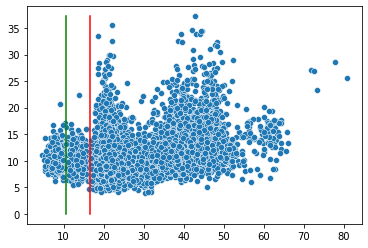

In [25]:
i=35
gene=genes[i]
print(gene)

loc=np.where(adataS.var['gene_names']==gene)[0]
exp=adataS.layers['scvi_normalized'][:,loc].T[0]
df=pd.DataFrame({'exp':exp, 'dist':dist})

sns.scatterplot(x=dist, y=exp)
plt.plot([cut0,cut0], [0,max(exp)], color='green')
plt.plot([cut1,cut1], [0,max(exp)], color='red')

df0=df[df.dist.between(0,cut0)]['exp']
df1=df[df.dist.between(cut0,cut1)]['exp']

t_stat=[a for a in scipy.stats.ttest_ind(list(df0), list(df1), alternative='greater', equal_var=False)]

print(t_stat)

mn0=df0.mean()
mn1=df1.mean()

print(mn0)
print(mn1)

print(df0.std()/mn0)
print(df1.std()/mn1)

sc.pl.umap(A0, color=gene)

In [ ]:
print(gene)

loc=np.where(adataS.var['gene_names']==gene)[0]

adataS.obs['gene']=adataS.layers['scvi_normalized'][:,loc]

sc.pl.umap(adataS, color='gene', vmax=2)

In [ ]:
sns.histplot(dist, bins=np.linspace(0,120,121))

In [ ]:
# from the umaps:
genesS=['Smad3', 'Gata6', 'Fgf8', 'Tdgf1', 'Sox17', 'Cldn6',  'Otx2', 'Irx3', 
       'Dkk1', 'Tbx1', 'Lhx1', 'Hhex', 'Gata4', 'Cer1', 'Irx1', 'Amot', 'Ihh', 'Hnf1b']

In [ ]:
genes_selected=[]
for gene in genes:
    t_val, p_val=calc_t_stat_cells(adataS, dist, gene, cut0, cut1)
    
    if p_val<10**-10:
        genes_selected.append(gene)

In [53]:
genes|hvgs

TypeError: unsupported operand type(s) for |: 'list' and 'list'

In [54]:
genes_selected=list(set(genes) & set(hvgs))

In [55]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    if gene in [a for a in adataS.var.index]:

        loc=adataS.var.index.get_loc(gene)
        exp=adataS.layers['scvi_normalized'][:,loc]
        #exp=adataS.X[:,loc]
        #exp=np.array(exp.todense()).T[0]
        
        if subset==True:
            wh=np.where(adataS.obs['cell_state']=='E7:Anterior primitive streak')[0]
            exp=exp[wh]
            gT2=gT[wh]
            gM2=gM[wh]
        else:
            gT2=gT.copy()
            gM2=gM.copy()

        (cor, p)=scipy.stats.spearmanr(exp, gT2)
        dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        (cor, p)=scipy.stats.spearmanr(exp, gM2)
        dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        DF=pd.concat([DF, dfT,dfM])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

In [62]:
DF.sort_values('Correlation')[40:]

,Timepoint,Gene,Method,Correlation,P-value,type,Abs. Correlation
34,E7.0,Dkk1,TOME,0.446407,4.751211e-35,Spearman,0.446407
31,E7.0,Furin,moscot,0.468036,8.423054e-39,Spearman,0.468036
48,E7.0,Gata6,TOME,0.486356,3.395704e-42,Spearman,0.486356
26,E7.0,Lefty1,TOME,0.500938,4.767336e-45,Spearman,0.500938
28,E7.0,Gata4,TOME,0.509170,1.014134e-46,Spearman,0.509170
62,E7.0,Irx1,TOME,0.533742,5.414187e-52,Spearman,0.533742
27,E7.0,Lefty1,moscot,0.537604,7.325274e-53,Spearman,0.537604
65,E7.0,Fgf8,moscot,0.561563,1.641609e-58,Spearman,0.561563
56,E7.0,Ihh,TOME,0.561892,1.363540e-58,Spearman,0.561892
38,E7.0,Sox7,TOME,0.571606,5.095187e-61,Spearman,0.571606


In [57]:
DF.iloc[0:50]

,Timepoint,Gene,Method,Correlation,P-value,type,Abs. Correlation
0,E7.0,Dsp,TOME,0.593103,1.090928e-66,Spearman,0.593103
1,E7.0,Dsp,moscot,0.614927,6.730761e-73,Spearman,0.614927
2,E7.0,Cldn6,TOME,0.418987,1.149704e-30,Spearman,0.418987
3,E7.0,Cldn6,moscot,0.391025,1.358862e-26,Spearman,0.391025
4,E7.0,Hnf4a,TOME,0.579281,5.384956e-63,Spearman,0.579281
5,E7.0,Hnf4a,moscot,0.669006,1.347820e-90,Spearman,0.669006
6,E7.0,Hhex,TOME,0.260749,3.587675e-12,Spearman,0.260749
7,E7.0,Hhex,moscot,0.317838,1.226363e-17,Spearman,0.317838
8,E7.0,Nanog,TOME,-0.438183,1.081512e-33,Spearman,0.438183
9,E7.0,Nanog,moscot,-0.449203,1.610190e-35,Spearman,0.449203


In [58]:
DF.iloc[50:]

,Timepoint,Gene,Method,Correlation,P-value,type,Abs. Correlation
50,E7.0,Foxa3,TOME,0.008372,8.263745e-01,Spearman,0.008372
51,E7.0,Foxa3,moscot,-0.128335,7.341816e-04,Spearman,0.128335
52,E7.0,Irx3,TOME,0.592022,2.152748e-66,Spearman,0.592022
53,E7.0,Irx3,moscot,0.724955,2.459063e-113,Spearman,0.724955
54,E7.0,Nodal,TOME,-0.161412,2.070810e-05,Spearman,0.161412
55,E7.0,Nodal,moscot,-0.179840,2.026213e-06,Spearman,0.179840
56,E7.0,Ihh,TOME,0.561892,1.363540e-58,Spearman,0.561892
57,E7.0,Ihh,moscot,0.594590,4.262518e-67,Spearman,0.594590
58,E7.0,Amot,TOME,0.652326,9.475630e-85,Spearman,0.652326
59,E7.0,Amot,moscot,0.787842,9.316633e-147,Spearman,0.787842


In [ ]:
pals=pal.copy()
pals[0]=pal[1]
pals[1]=pal[0]

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 10))
sns.boxplot(data=DF, x="Correlation", y="Timepoint", hue='Method',
               showmeans=False,  whis=[100,0], ax=ax, palette=pals)

In [ ]:
DF.to_pickle(f'{Path}/Correlations/DE.npy')

In [ ]:
DF[DF['Method']=='TOME']['Correlation'].mean()

In [ ]:
DF[DF['Method']=='moscot']['Correlation'].mean()

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 10))
sns.boxplot(data=DF, x="Correlation", y="Timepoint", hue='Method',
               showmeans=False,  whis=[100,0], ax=ax, palette=pals)

In [12]:
DF

NameError: name 'DF' is not defined

In [ ]:
E7.0	Amot	moscot	0.776457
E7.0	Amot	TOME	0.652326

Hnf1b	TOME	0.630571
Hnf1b	moscot	0.783274

E7.0	Gata4	moscot	0.729856
E7.0	Gata4	TOME	0.509170